In [42]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from math import sqrt
from matplotlib import pyplot
from numpy import array
import numpy as np
from keras.layers import LSTM , CuDNNLSTM
import matplotlib.pyplot as plt
import pandas as pd
sns.set()

In [2]:
cd electric_time_series/

/mlsteam/lab/electric_time_series


Load the file

In [56]:
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset = dataset.reset_index()

In [57]:
dataset[['datetime']] = dataset[['datetime']].astype(str)


In [58]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
datetime                 object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
sub_metering_4           float64
dtypes: float64(8), object(1)
memory usage: 142.5+ MB


In [60]:
dataset.isnull().sum()

datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

In [61]:
dataset = dataset.drop(['datetime'], axis=1)


In [62]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [63]:
dataset.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,0.247088,-0.396853,0.998884,0.484110,0.434012,0.638966,0.700756
Global_reactive_power,0.247088,1.000000,-0.110802,0.266219,0.123006,0.139321,0.089949,0.211442
Voltage,-0.396853,-0.110802,1.000000,-0.408480,-0.195018,-0.165702,-0.265935,-0.269298
Global_intensity,0.998884,0.266219,-0.408480,1.000000,0.489027,0.439780,0.626952,0.702647
Sub_metering_1,0.484110,0.123006,-0.195018,0.489027,1.000000,0.054468,0.101996,0.124699
Sub_metering_2,0.434012,0.139321,-0.165702,0.439780,0.054468,1.000000,0.081440,0.084800
Sub_metering_3,0.638966,0.089949,-0.265935,0.626952,0.101996,0.081440,1.000000,0.177762
sub_metering_4,0.700756,0.211442,-0.269298,0.702647,0.124699,0.084800,0.177762,1.000000


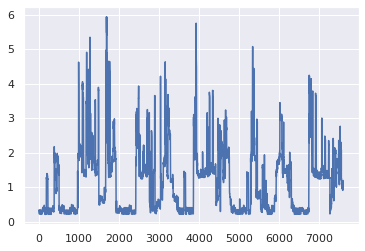

In [64]:
plt_elec_data = dataset['Global_active_power'][-245*31:].values
plt.plot(plt_elec_data)

In [65]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [98]:
# configure
n_lag = 60
look_back = n_lag
n_seq = 10
pred_length = n_seq
features = 8
n_neurons = 64
n_batch = 24

In [99]:
#multivariate
seq2seq_raw_values = dataset.values
test_value = seq2seq_raw_values[:,0].reshape(len(seq2seq_raw_values),1)
# rescale values to -1, 1
scaler_trans = MinMaxScaler(feature_range=(-1, 1))
transfor_fun = scaler_trans.fit_transform(test_value)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(seq2seq_raw_values)
########################
#scaled_values = seq2seq_raw_values
#print(scaled_values[:27])
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
supervised_values.shape
train, test = supervised_values[-245*30:-245*1], supervised_values[-245*1:]

print('train',train.shape)
print('test',test.shape)

train (7105, 560)
test (245, 560)


In [100]:
encoder_input_data , decoder_target_data = train[: , :n_lag*features] , train[:, n_lag*features:]
decoder_target_data = decoder_target_data[: , ::features]
encoder_input_data = encoder_input_data.reshape((encoder_input_data.shape[0], n_lag, features))
decoder_target_data = decoder_target_data.reshape((decoder_target_data.shape[0],decoder_target_data.shape[1],1))
print("encoder_input_data",encoder_input_data.shape,"decoder_target_data",decoder_target_data.shape)

encoder_input_data (7105, 60, 8) decoder_target_data (7105, 10, 1)


In [101]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(encoder_input_data.shape[1], encoder_input_data.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(pred_length))

model.add(TimeDistributed(Dense(64)))
model.add(CuDNNLSTM(64,  return_sequences=True))
model.add(Activation('tanh'))

model.add(TimeDistributed(Dense(32, activation='relu')))
model.add(TimeDistributed(Dense(10, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')


In [102]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 59, 64)            1088      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 29, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 28, 64)            8256      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 896)               0         
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 10, 896)           0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 10, 64)           

In [103]:
history = model.fit(encoder_input_data,
                  decoder_target_data,
                  n_batch,
                  nb_epoch=100,
                  validation_split=0.15,
                  verbose=1)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6039 samples, validate on 1066 samples
Epoch 1/100
6039/6039 [==============================] - 6s 1ms/step - loss: 0.0356 - val_loss: 0.0149
Epoch 2/100
6039/6039 [==============================] - 3s 489us/step - loss: 0.0115 - val_loss: 0.0090
Epoch 3/100
6039/6039 [==============================] - 3s 488us/step - loss: 0.0104 - val_loss: 0.0094
Epoch 4/100
6039/6039 [==============================] - 3s 495us/step - loss: 0.0092 - val_loss: 0.0076
Epoch 5/100
6039/6039 [==============================] - 3s 493us/step - loss: 0.0086 - val_loss: 0.0087
Epoch 6/100
6039/6039 [==============================] - 3s 484us/step - loss: 0.0081 - val_loss: 0.0083
Epoch 7/100
6039/6039 [==============================] - 3s 484us/step - loss: 0.0077 - val_loss: 0.0070
Epoch 8/100
6039/6039 [==============================] - 3s 484us/step - loss: 0.0074 - val_loss: 0.0068
Epoch 9/100
6039/6039 [==============================] - 3s 491us/step - loss: 0.0071 - val_loss: 0.0072
Epoch 10/

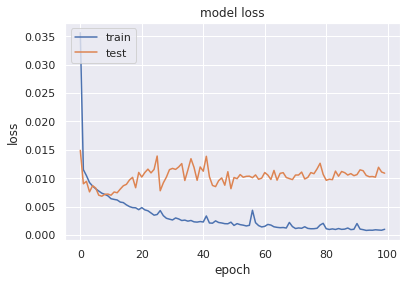

In [104]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Testing data 

In [105]:
test_encoder_input_data , test_output_seq = test[: , :n_lag*features] , test[:, n_lag*features:]
test_output_seq = test_output_seq[: , ::features]
test_encoder_input_data = test_encoder_input_data.reshape((test_encoder_input_data.shape[0], n_lag, features))
test_output_seq = test_output_seq.reshape((test_output_seq.shape[0],test_output_seq.shape[1],1))
print("test_encoder_input_data",test_encoder_input_data.shape,"test_output_seq",test_output_seq.shape)

test_encoder_input_data (245, 60, 8) test_output_seq (245, 10, 1)


In [106]:
forecasts = model.predict(test_encoder_input_data)
forecasts.shape

(245, 10, 1)

In [107]:
forecasts_BBBB=list()
for i in range(len(forecasts)):
    forecasts_BBBB.append(forecasts[i,:])
	
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	b = np.array([0.0])
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + b)
	return inverted
	
import numpy as np
forecast_pred = list()
for i in range(len(forecasts)):
	# create array from forecast
	forecast = array(forecasts_BBBB[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	forecast_pred.append(inv_diff)

forecast_14steps = forecast_pred
actual = [row[:] for row in test_output_seq]
actual_value = list()
for i in range(len(actual)):
	# create array from forecast
	forecast = array(actual[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	actual_value.append(inv_diff)
 

In [108]:
#7day
day = n_seq
actual_np = np.zeros(len(forecast_14steps))
print(actual_np.shape)
#c = 0
#abc[0] = actual_value[6][0]
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            #print('i=',i,'j=',j,'i+j=',i+j)
            if (i/day)< (len(forecast_14steps)/day) :
                actual_np[j+i] = actual_value[i+day-1][j]
                #print(actual_value[i+day-1][j])
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                actual_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = actual_value[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]
                #print(actual_value[i+day-1][j])
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
    else:
        #print('i=',i,print(actual_np))
        
        for j in range(len(test)%day):
            #print(actual_np[i+j])
            #print(actual_value[-1][j-5])
            actual_np[i+j] = actual_value[-1][j-(len(test)%day)]
            #actual_np[i+j] = actual_value[-1][j+1]
        
            
#print(actual_np)

(245,)


In [109]:
pred_np = np.zeros(len(forecast_14steps))
#c = 0
#abc[0] = actual_value[6][0]
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            if (i/day)< (len(forecast_14steps)/day) :
                pred_np[j+i] = forecast_14steps[i+day-1][j]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                pred_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = forecast_14steps[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
    else:
        for j in range(len(test)%day):
            pred_np[i+j] = forecast_14steps[-1][j-(len(test)%day)]

In [111]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(actual_np, pred_np))
print('RMSE: %.3f' % rmse)

RMSE: 0.717


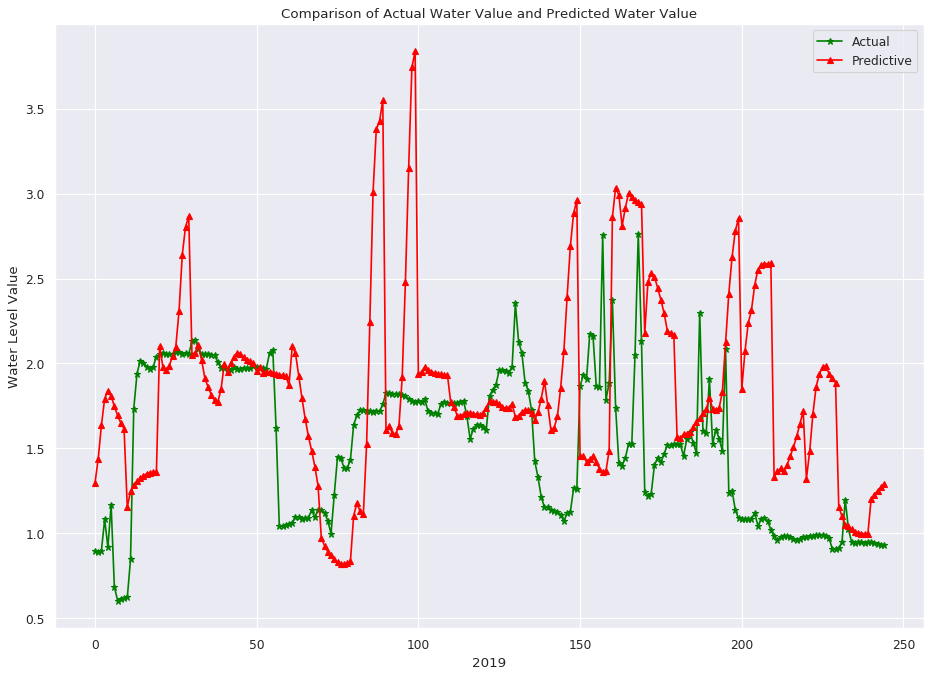

In [112]:
x_axis = np.arange(len(test))
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Comparison of Actual Water Value and Predicted Water Value')
plt.plot(actual_np,'*-', color='green', label='Actual')
plt.plot(pred_np, '^-', color='red', label='Predictive')
plt.legend() # 显示图例
plt.xlabel('2019')
plt.ylabel('Water Level Value')
plt.show()